
# Text Preprocessing for EN→DE Speech Translation

**Project:** NNAA — STT Translation (English speech → English text → German text)  
**Dataset:** Common Voice v4 (TSV + MP3) + CoVoST v2 EN→DE (`covost_v2.en_de.tsv`)  
**OS:** Windows · **Conda env:** `seq2seq`

This notebook prepares **parallel text** (English ↔ German) aligned to your audio clips.  
It focuses on clean normalization, **length & ratio filtering**, **shared SentencePiece** vocabulary, and **visual sanity checks**.

> Why this matters: Clean text and a well-matched subword vocab reduce label noise for ASR and stabilize the downstream MT training.



## Requirements

- Python: `pandas`, `numpy`, `regex`, `sentencepiece`, `matplotlib`, `tqdm`, `unicodedata2` (optional), `ftfy` (optional)
- Files on disk (as per your project notes):
  - Common Voice v4 TSVs: `validated.tsv`, `train.tsv`, `dev.tsv`, `test.tsv`, `invalidated.tsv`, `other.tsv`
  - Common Voice clips folder: `E:/datasets/common_voice_4/clips/`
  - CoVoST EN→DE: `E:/datasets/common_voice_4/covost_v2.en_de.tsv`

If you don't have `sentencepiece` yet:

```bash
conda install -n seq2seq -c conda-forge sentencepiece
# or: pip install sentencepiece
```


In [1]:

# --- Config & Imports ---
from pathlib import Path
import os, re, json, html
from collections import Counter
from typing import Tuple, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

# Optional but helpful
try:
    import regex as re2  # better Unicode handling
    _RE = re2
except Exception:
    _RE = re  # fallback

try:
    import sentencepiece as spm
    HAS_SPM = True
except Exception:
    HAS_SPM = False

# Paths (Windows)
BASE = Path(r"E:/datasets/common_voice_4")
CLIPS = BASE / "clips"
COVOST = BASE / "covost_v2.en_de.tsv"
CV_SPLITS = ["validated.tsv", "train.tsv", "dev.tsv", "test.tsv", "invalidated.tsv", "other.tsv"]

# Outputs
OUT_DIR = BASE / "text_outputs"
VOCAB_DIR = OUT_DIR / "spm"
CLEAN_DIR = OUT_DIR / "cleaned"

OUT_DIR.mkdir(parents=True, exist_ok=True)
VOCAB_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

# SentencePiece params
VOCAB_SIZE = 16000  # 8k–32k are common; tune later
MODEL_TYPE = "unigram"  # "unigram" or "bpe"
MODEL_PREFIX = (VOCAB_DIR / f"spm_shared_{MODEL_TYPE}_{VOCAB_SIZE}").as_posix()

# Filtering params (token-based)
MAX_TOK_EN = 200
MAX_TOK_DE = 200
MAX_CHAR_EN = 1200
MAX_CHAR_DE = 1200
MAX_LEN_RATIO = 3.0   # max( len(src)/len(tgt), len(tgt)/len(src) ) <= this
MIN_TOK = 1

RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)



## 1) Text Cleaning

Rules aim to be **conservative** (do not over-normalize). We:
- Unicode normalize (NFKC), strip zero-width chars
- Fix common whitespace/punct spacing
- Lowercase **English** only (German casing carries meaning; keep as-is)
- Keep basic punctuation; collapse repeats
- Remove spurious transcription artifacts (e.g., `[noise]`, `<unk>`) when present


In [2]:

import unicodedata

ZW_RE = _RE.compile(r"[\u200B-\u200D\uFEFF]")
MULTISPACE_RE = _RE.compile(r"\s+")
PUNCT_SPACE_RE = _RE.compile(r"\s([!?,.;:])")
SPACE_PUNCT_RE = _RE.compile(r"([({\[\-])\s+")
REPEAT_PUNCT_RE = _RE.compile(r"([!?.]){3,}")  # '!!!' -> '!!'

BRACKETED_JUNK_RE = _RE.compile(r"\[(?:noise|laugh|music|cough|breath|silence)\]", _RE.IGNORECASE)
TAG_JUNK_RE = _RE.compile(r"<(?:unk|noise|sil|\/?s)>", _RE.IGNORECASE)

def uclean(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = html.unescape(s)
    s = unicodedata.normalize("NFKC", s)
    s = ZW_RE.sub("", s)
    s = BRACKETED_JUNK_RE.sub("", s)
    s = TAG_JUNK_RE.sub("", s)
    s = s.replace("\u00A0", " ")
    s = MULTISPACE_RE.sub(" ", s).strip()
    s = PUNCT_SPACE_RE.sub(r"\1", s)
    s = SPACE_PUNCT_RE.sub(r"\1", s)
    s = REPEAT_PUNCT_RE.sub(r"\1\1", s)
    return s

def clean_en(s: str) -> str:
    s = uclean(s)
    # lowercase English (safer); keep apostrophes
    return s.lower()

def clean_de(s: str) -> str:
    s = uclean(s)
    # keep German casing; fix common quotes
    s = s.replace('\u201e', '„').replace('\u201c', '“').replace('"', '„')
    s = s.replace("„ ", "„").replace(" “", "“")
    return s

def length_stats(texts):
    lens = np.array([len(t) for t in texts], dtype=np.int32)
    return {
        "count": int(lens.size),
        "mean": float(lens.mean()) if lens.size else 0.0,
        "p50": float(np.percentile(lens, 50)) if lens.size else 0.0,
        "p90": float(np.percentile(lens, 90)) if lens.size else 0.0,
        "p99": float(np.percentile(lens, 99)) if lens.size else 0.0,
        "max": float(lens.max()) if lens.size else 0.0,
    }



## 2) Load & Merge (Common Voice ↔ CoVoST by `path`)

We join each CV split TSV (for `sentence`) with CoVoST EN→DE (for `translation`) on the shared `path` field.
This yields aligned pairs `(en_text, de_text)` and the absolute `audio_path`.


In [3]:

def load_covost(covost_path: Path) -> pd.DataFrame:
    df = pd.read_csv(covost_path, sep="\t")
    # Find translation column (varies by version)
    cand = [c for c in df.columns if c.lower().startswith("translation") or c.endswith("_de")]
    trans_col = cand[0] if cand else "translation"
    need = ["path", trans_col]
    df = df[need].rename(columns={trans_col: "de_text"})
    return df

def load_cv_split(base: Path, split_file: str) -> pd.DataFrame:
    p = base / split_file
    df = pd.read_csv(p, sep="\t")
    en_col = "sentence" if "sentence" in df.columns else "text"
    need = ["path", en_col]
    df = df[need].rename(columns={en_col: "en_text"})
    return df

covost = load_covost(COVOST)
rows = []
for split in CV_SPLITS:
    try:
        cv = load_cv_split(BASE, split)
        merged = pd.merge(cv, covost, on="path", how="inner")
        merged["split"] = split.replace(".tsv","")
        merged["audio_path"] = merged["path"].apply(lambda p: (CLIPS / p).as_posix())
        rows.append(merged)
        print(f"{split:<15} matched {len(merged):>8} rows")
    except Exception as e:
        print(f"{split:<15} ERROR: {e}")

raw_all = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["path","en_text","de_text","split","audio_path"])
print("TOTAL:", len(raw_all))
raw_all.head(3)


C:\Users\Grace\AppData\Local\Temp\ipykernel_71028\938640283.py:12: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(p, sep="\t")


validated.tsv   matched   799608 rows
train.tsv       matched   219399 rows
dev.tsv         matched    12830 rows
test.tsv        matched    15531 rows
invalidated.tsv matched        0 rows
other.tsv       matched        0 rows
TOTAL: 1047368


,path,en_text,de_text,split,audio_path
0,common_voice_en_699711.mp3,She'll be all right.,Sie wird schon in Ordnung sein.,validated,E:/datasets/common_voice_4/clips/common_voice_...
1,common_voice_en_18132047.mp3,All's well that ends well.,"Ende gut, alles gut.",validated,E:/datasets/common_voice_4/clips/common_voice_...
2,common_voice_en_17263741.mp3,Do you mean it?,Meinst du das wirklich so?,validated,E:/datasets/common_voice_4/clips/common_voice_...



## 3) Inspect & Clean

We preview random pairs before/after cleaning and plot **length distributions** to catch anomalies.


In [4]:

# Sample preview
preview = raw_all.sample(n=min(8, len(raw_all)), random_state=RANDOM_SEED).copy()
preview["en_clean"] = preview["en_text"].map(clean_en)
preview["de_clean"] = preview["de_text"].map(clean_de)
preview[["en_text","en_clean","de_text","de_clean"]]


,en_text,en_clean,de_text,de_clean
328691,I'm in the pink of condition.,i'm in the pink of condition.,Ich bin in bester Verfassung.,Ich bin in bester Verfassung.
511407,I travelled with half a dozen in an atmosphere...,i travelled with half a dozen in an atmosphere...,Ich fuhr mit einem halben Dutzend von ihnen in...,Ich fuhr mit einem halben Dutzend von ihnen in...
265889,It must be some kind of a gag.,it must be some kind of a gag.,Es muss eine Art Knebel sein.,Es muss eine Art Knebel sein.
286472,He transformed himself into a stone that rolle...,he transformed himself into a stone that rolle...,"Er verwandelte sich in einen Stein, der bis zu...","Er verwandelte sich in einen Stein, der bis zu..."
211398,You're through deciding anything!,you're through deciding anything!,Du hast überhaupt nichts mehr zu sagen!,Du hast überhaupt nichts mehr zu sagen!
411933,It's the Master Work of the alchemists.,it's the master work of the alchemists.,Es ist der Alchemisten Meisterwerk.,Es ist der Alchemisten Meisterwerk.
594983,"Glass eel is on the menu today, but it's too e...","glass eel is on the menu today, but it's too e...","Glasaal ist heute auf der Speisekarte, ist abe...","Glasaal ist heute auf der Speisekarte, ist abe..."
292085,How can we reconcile this conflict?,how can we reconcile this conflict?,Wie können wir diesen Konflikt beilegen?,Wie können wir diesen Konflikt beilegen?


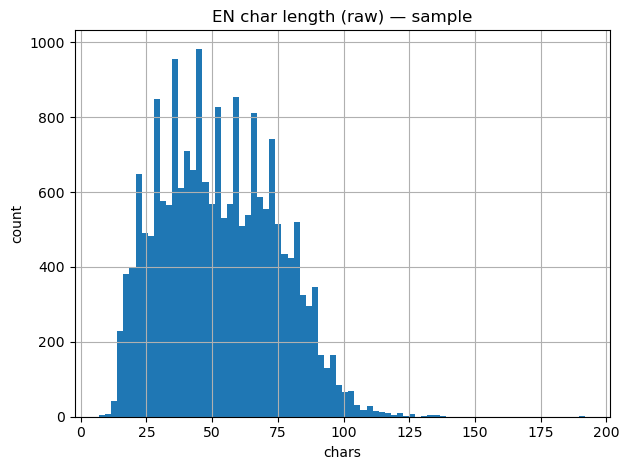

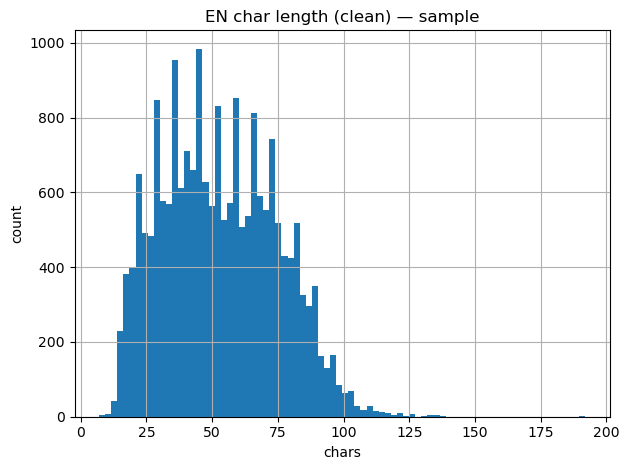

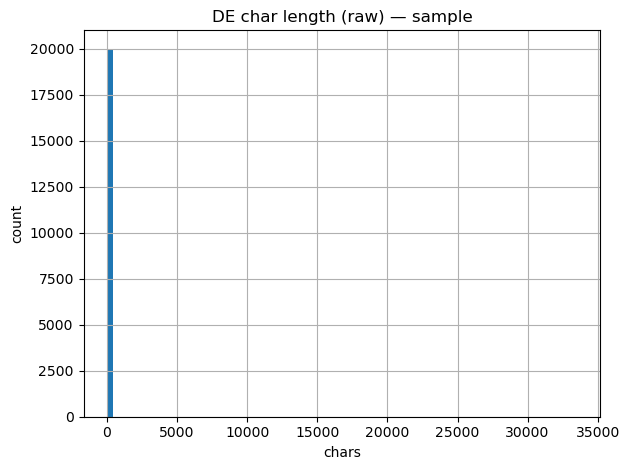

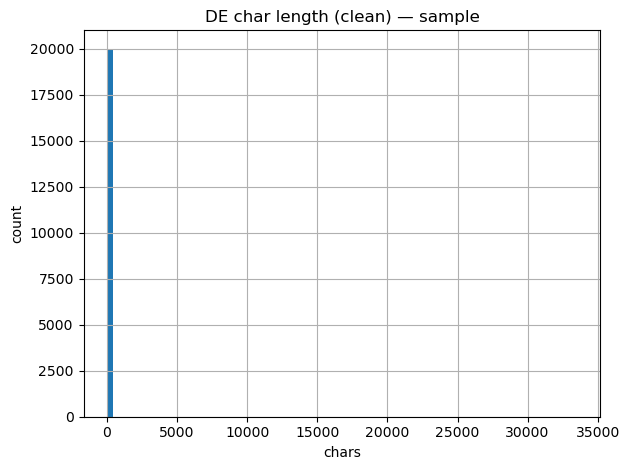

In [5]:

# Char-length histograms (matplotlib only; one plot per figure)
subset = raw_all.sample(n=min(20000, len(raw_all)), random_state=RANDOM_SEED).copy()

subset["en_len_raw"] = subset["en_text"].astype(str).map(len)
subset["de_len_raw"] = subset["de_text"].astype(str).map(len)
subset["en_len_clean"] = subset["en_text"].map(clean_en).map(len)
subset["de_len_clean"] = subset["de_text"].map(clean_de).map(len)

# EN raw
plt.figure()
plt.hist(subset["en_len_raw"].values, bins=80)
plt.title("EN char length (raw) — sample")
plt.xlabel("chars"); plt.ylabel("count")
plt.grid(True); plt.tight_layout(); plt.show()

# EN clean
plt.figure()
plt.hist(subset["en_len_clean"].values, bins=80)
plt.title("EN char length (clean) — sample")
plt.xlabel("chars"); plt.ylabel("count")
plt.grid(True); plt.tight_layout(); plt.show()

# DE raw
plt.figure()
plt.hist(subset["de_len_raw"].values, bins=80)
plt.title("DE char length (raw) — sample")
plt.xlabel("chars"); plt.ylabel("count")
plt.grid(True); plt.tight_layout(); plt.show()

# DE clean
plt.figure()
plt.hist(subset["de_len_clean"].values, bins=80)
plt.title("DE char length (clean) — sample")
plt.xlabel("chars"); plt.ylabel("count")
plt.grid(True); plt.tight_layout(); plt.show()



## 4) Train a **Shared** SentencePiece Model (train-only)

We follow the Seq2Seq practice:
- Train on **train** split only
- Use **language tags** (`<en>`, `<de>`) to help the model keep languages apart
- Save `.model` and `.vocab` under `text_outputs/spm/`

> If `sentencepiece` is not installed, run the install command above and restart the kernel.


In [6]:

# Collect train-only text with language tags
train_df = raw_all[raw_all["split"]=="train"].copy()

train_en = train_df["en_text"].astype(str).map(clean_en).tolist()
train_de = train_df["de_text"].astype(str).map(clean_de).tolist()

# Write a temporary training corpus with language tags
spm_corpus = VOCAB_DIR / "spm_corpus.txt"
with spm_corpus.open("w", encoding="utf-8") as f:
    for s in train_en:
        f.write("<en> " + s + "\n")
    for s in train_de:
        f.write("<de> " + s + "\n")

if HAS_SPM:
    spm.SentencePieceTrainer.Train(
        input=spm_corpus.as_posix(),
        model_prefix=MODEL_PREFIX,
        vocab_size=VOCAB_SIZE,
        model_type=MODEL_TYPE,
        character_coverage=1.0,
        user_defined_symbols=["<en>","<de>"],
        input_sentence_size=0,  # 0 = use full corpus
        shuffle_input_sentence=True
    )
    print("Trained:", MODEL_PREFIX + ".model")
else:
    print("SentencePiece not available. Install it and re-run this cell.")


Trained: E:/datasets/common_voice_4/text_outputs/spm/spm_shared_unigram_16000.model



## 5) Tokenize & Filter by Length / Ratio

We compute SPM token lengths and filter pairs that are too long or have extreme length ratios.

- Drop if `len(en_tokens) > MAX_TOK_EN` or `len(de_tokens) > MAX_TOK_DE`
- Drop if `max(len(en)/len(de), len(de)/len(en)) > MAX_LEN_RATIO`
- Also apply **character** length caps as a safety net


In [7]:

# Load spm model
sp = None
if HAS_SPM and Path(MODEL_PREFIX + ".model").exists():
    sp = spm.SentencePieceProcessor()
    sp.load(MODEL_PREFIX + ".model")
else:
    print("SPM model not found — skipping token-based filtering.")

def sp_encode_len(text: str) -> int:
    if sp is None:
        return len(text.split())  # fallback
    return len(sp.encode(text, out_type=str))

def filter_df(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d["en_c"] = d["en_text"].map(clean_en)
    d["de_c"] = d["de_text"].map(clean_de)

    d["en_tok"] = d["en_c"].map(sp_encode_len)
    d["de_tok"] = d["de_c"].map(sp_encode_len)
    d["en_char"] = d["en_c"].map(len)
    d["de_char"] = d["de_c"].map(len)

    # length ratio
    eps = 1e-6
    d["len_ratio"] = np.maximum((d["en_tok"]+eps)/(d["de_tok"]+eps), (d["de_tok"]+eps)/(d["en_tok"]+eps))

    # masks
    m_tok = (d["en_tok"].between(MIN_TOK, MAX_TOK_EN)) & (d["de_tok"].between(MIN_TOK, MAX_TOK_DE))
    m_char = (d["en_char"] <= MAX_CHAR_EN) & (d["de_char"] <= MAX_CHAR_DE)
    m_ratio = (d["len_ratio"] <= MAX_LEN_RATIO)

    keep = m_tok & m_char & m_ratio
    return d.loc[keep, ["path","audio_path","en_c","de_c","en_tok","de_tok","len_ratio"]].rename(columns={"en_c":"en_text","de_c":"de_text"})

# Apply per split & save
clean_counts = {}
for split in sorted(raw_all["split"].unique()):
    part = raw_all[raw_all["split"]==split]
    cleaned = filter_df(part)
    out_path = CLEAN_DIR / f"{split}_en-de_clean.tsv"
    cleaned.to_csv(out_path, sep="\t", index=False)
    clean_counts[split] = (len(part), len(cleaned))
    print(f"{split:>10}: kept {len(cleaned):>8} / {len(part):>8}  →  {out_path.name}")

clean_counts


       dev: kept    12821 /    12830  →  dev_en-de_clean.tsv
      test: kept    15523 /    15531  →  test_en-de_clean.tsv
     train: kept   219252 /   219399  →  train_en-de_clean.tsv
 validated: kept   798864 /   799608  →  validated_en-de_clean.tsv


{'dev': (12830, 12821),
 'test': (15531, 15523),
 'train': (219399, 219252),
 'validated': (799608, 798864)}


## 6) Visualize Token Lengths & Ratios (post-filter)

We verify that distributions look sensible after filtering.


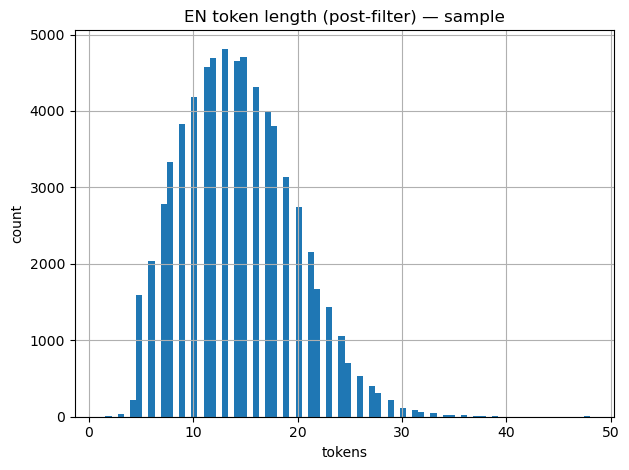

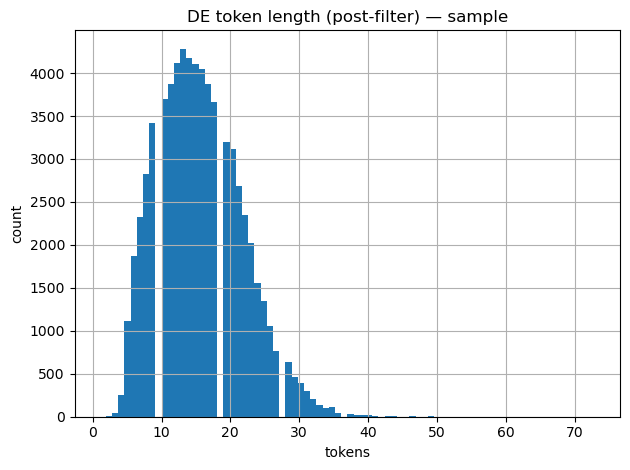

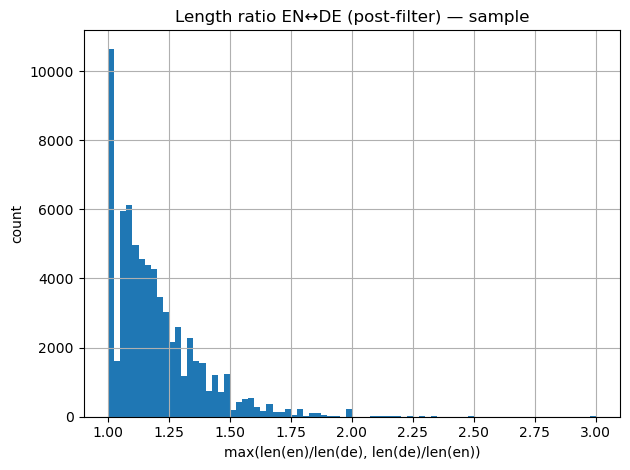

In [8]:

# Combine a sample for plotting
plot_parts = []
for split in sorted(raw_all["split"].unique()):
    p = CLEAN_DIR / f"{split}_en-de_clean.tsv"
    if p.exists():
        dfp = pd.read_csv(p, sep="\t")
        dfp["split"] = split
        plot_parts.append(dfp.sample(n=min(20000, len(dfp)), random_state=RANDOM_SEED))
post = pd.concat(plot_parts, ignore_index=True) if plot_parts else pd.DataFrame()

if len(post):
    # EN token length
    plt.figure()
    plt.hist(post["en_tok"].values, bins=80)
    plt.title("EN token length (post-filter) — sample")
    plt.xlabel("tokens"); plt.ylabel("count")
    plt.grid(True); plt.tight_layout(); plt.show()

    # DE token length
    plt.figure()
    plt.hist(post["de_tok"].values, bins=80)
    plt.title("DE token length (post-filter) — sample")
    plt.xlabel("tokens"); plt.ylabel("count")
    plt.grid(True); plt.tight_layout(); plt.show()

    # Length ratio
    plt.figure()
    plt.hist(post["len_ratio"].values, bins=80)
    plt.title("Length ratio EN↔DE (post-filter) — sample")
    plt.xlabel("max(len(en)/len(de), len(de)/len(en))"); plt.ylabel("count")
    plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("No cleaned data found for plotting.")



## 7) Tiny Toy Files (optional)

For quick experiments/CI, we export very small subsets.


In [9]:

toy = {}
for split in ["train","dev","test","validated"]:
    p = CLEAN_DIR / f"{split}_en-de_clean.tsv"
    if p.exists():
        d = pd.read_csv(p, sep="\t")
        toy_d = d.head(100).copy()
        toy_p = CLEAN_DIR / f"{split}_toy100_en-de.tsv"
        toy_d.to_csv(toy_p, sep="\t", index=False)
        toy[split] = toy_p.as_posix()
toy


{'train': 'E:/datasets/common_voice_4/text_outputs/cleaned/train_toy100_en-de.tsv',
 'dev': 'E:/datasets/common_voice_4/text_outputs/cleaned/dev_toy100_en-de.tsv',
 'test': 'E:/datasets/common_voice_4/text_outputs/cleaned/test_toy100_en-de.tsv',
 'validated': 'E:/datasets/common_voice_4/text_outputs/cleaned/validated_toy100_en-de.tsv'}


## Notes for Downstream ASR→MT

- Use the **same SentencePiece** for both EN (ASR targets) and DE (MT targets) if you plan a unified pipeline.
- If you prefer, train **two vocabularies** (one per language) — adjust code where we compute token lengths.
- Keep your **speaker-disjoint** audio split (done on the audio side). This notebook does not change that; it just cleans texts by split name.
- Re-run this notebook after any changes to filtering params.
